In [318]:
# Импорт необходимых библиотек 
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


import time
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import plot_confusion_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import  RidgeClassifier,SGDClassifier
from sklearn.metrics import f1_score, roc_curve, auc,accuracy_score ,roc_auc_score
from sklearn.model_selection import train_test_split,KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [319]:
# Выгрузка данных 
data = pd.read_csv('exam_dataset.csv')

In [320]:
data.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [321]:
# Информация о датасете
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


In [322]:
# Вывод числа уникальных значений датасета по признакам
for column in data:
    print(f"Количество уникальный значений в столбце {column} : {data[column].nunique()}")

Количество уникальный значений в столбце Loan_ID : 614
Количество уникальный значений в столбце Gender : 2
Количество уникальный значений в столбце Married : 2
Количество уникальный значений в столбце Dependents : 4
Количество уникальный значений в столбце Education : 2
Количество уникальный значений в столбце Self_Employed : 2
Количество уникальный значений в столбце ApplicantIncome : 505
Количество уникальный значений в столбце CoapplicantIncome : 287
Количество уникальный значений в столбце LoanAmount : 203
Количество уникальный значений в столбце Loan_Amount_Term : 10
Количество уникальный значений в столбце Credit_History : 2
Количество уникальный значений в столбце Property_Area : 3
Количество уникальный значений в столбце Loan_Status : 2


In [323]:
# Обработка признака Dependents
for i in range(len(data['Dependents'])):
    try:
        data.loc[[i],['Dependents']] = int(data['Dependents'][i][0])
    except:
        data.loc[[i],['Dependents']] = np.NaN
data['Dependents'] = data['Dependents'].fillna(np.mean(data['Dependents']))

In [324]:
# Обработка категориальных данных (Значений немного, можно заменить на 0, 0.5, 1)
data['Property_Area'] = data['Property_Area'].map({'Urban':0,'Rural':1, 'Semiurban': 0.5})
data['Gender'] = data['Gender'].map({'Female':0,'Male':1})
data['Married'] = data['Married'].map({'No': 0, 'Yes': 1})
data['Loan_Status'] = data['Loan_Status'].map({'N' : 0 , 'Y' : 1 })
data['Self_Employed'] = data['Self_Employed'].map({'No': 0, 'Yes': 1})
data['Education'] = data['Education'].map({'Not Graduate': 0, 'Graduate': 1})

In [325]:
# Заполнение пропущенных данных
for column in data:
    if data[column].dtype != 'object':
        data[column] = data[column].fillna(value = np.mean(data[column]))
    else:
        data[column] = data[column].fillna(value = data[column].mode())

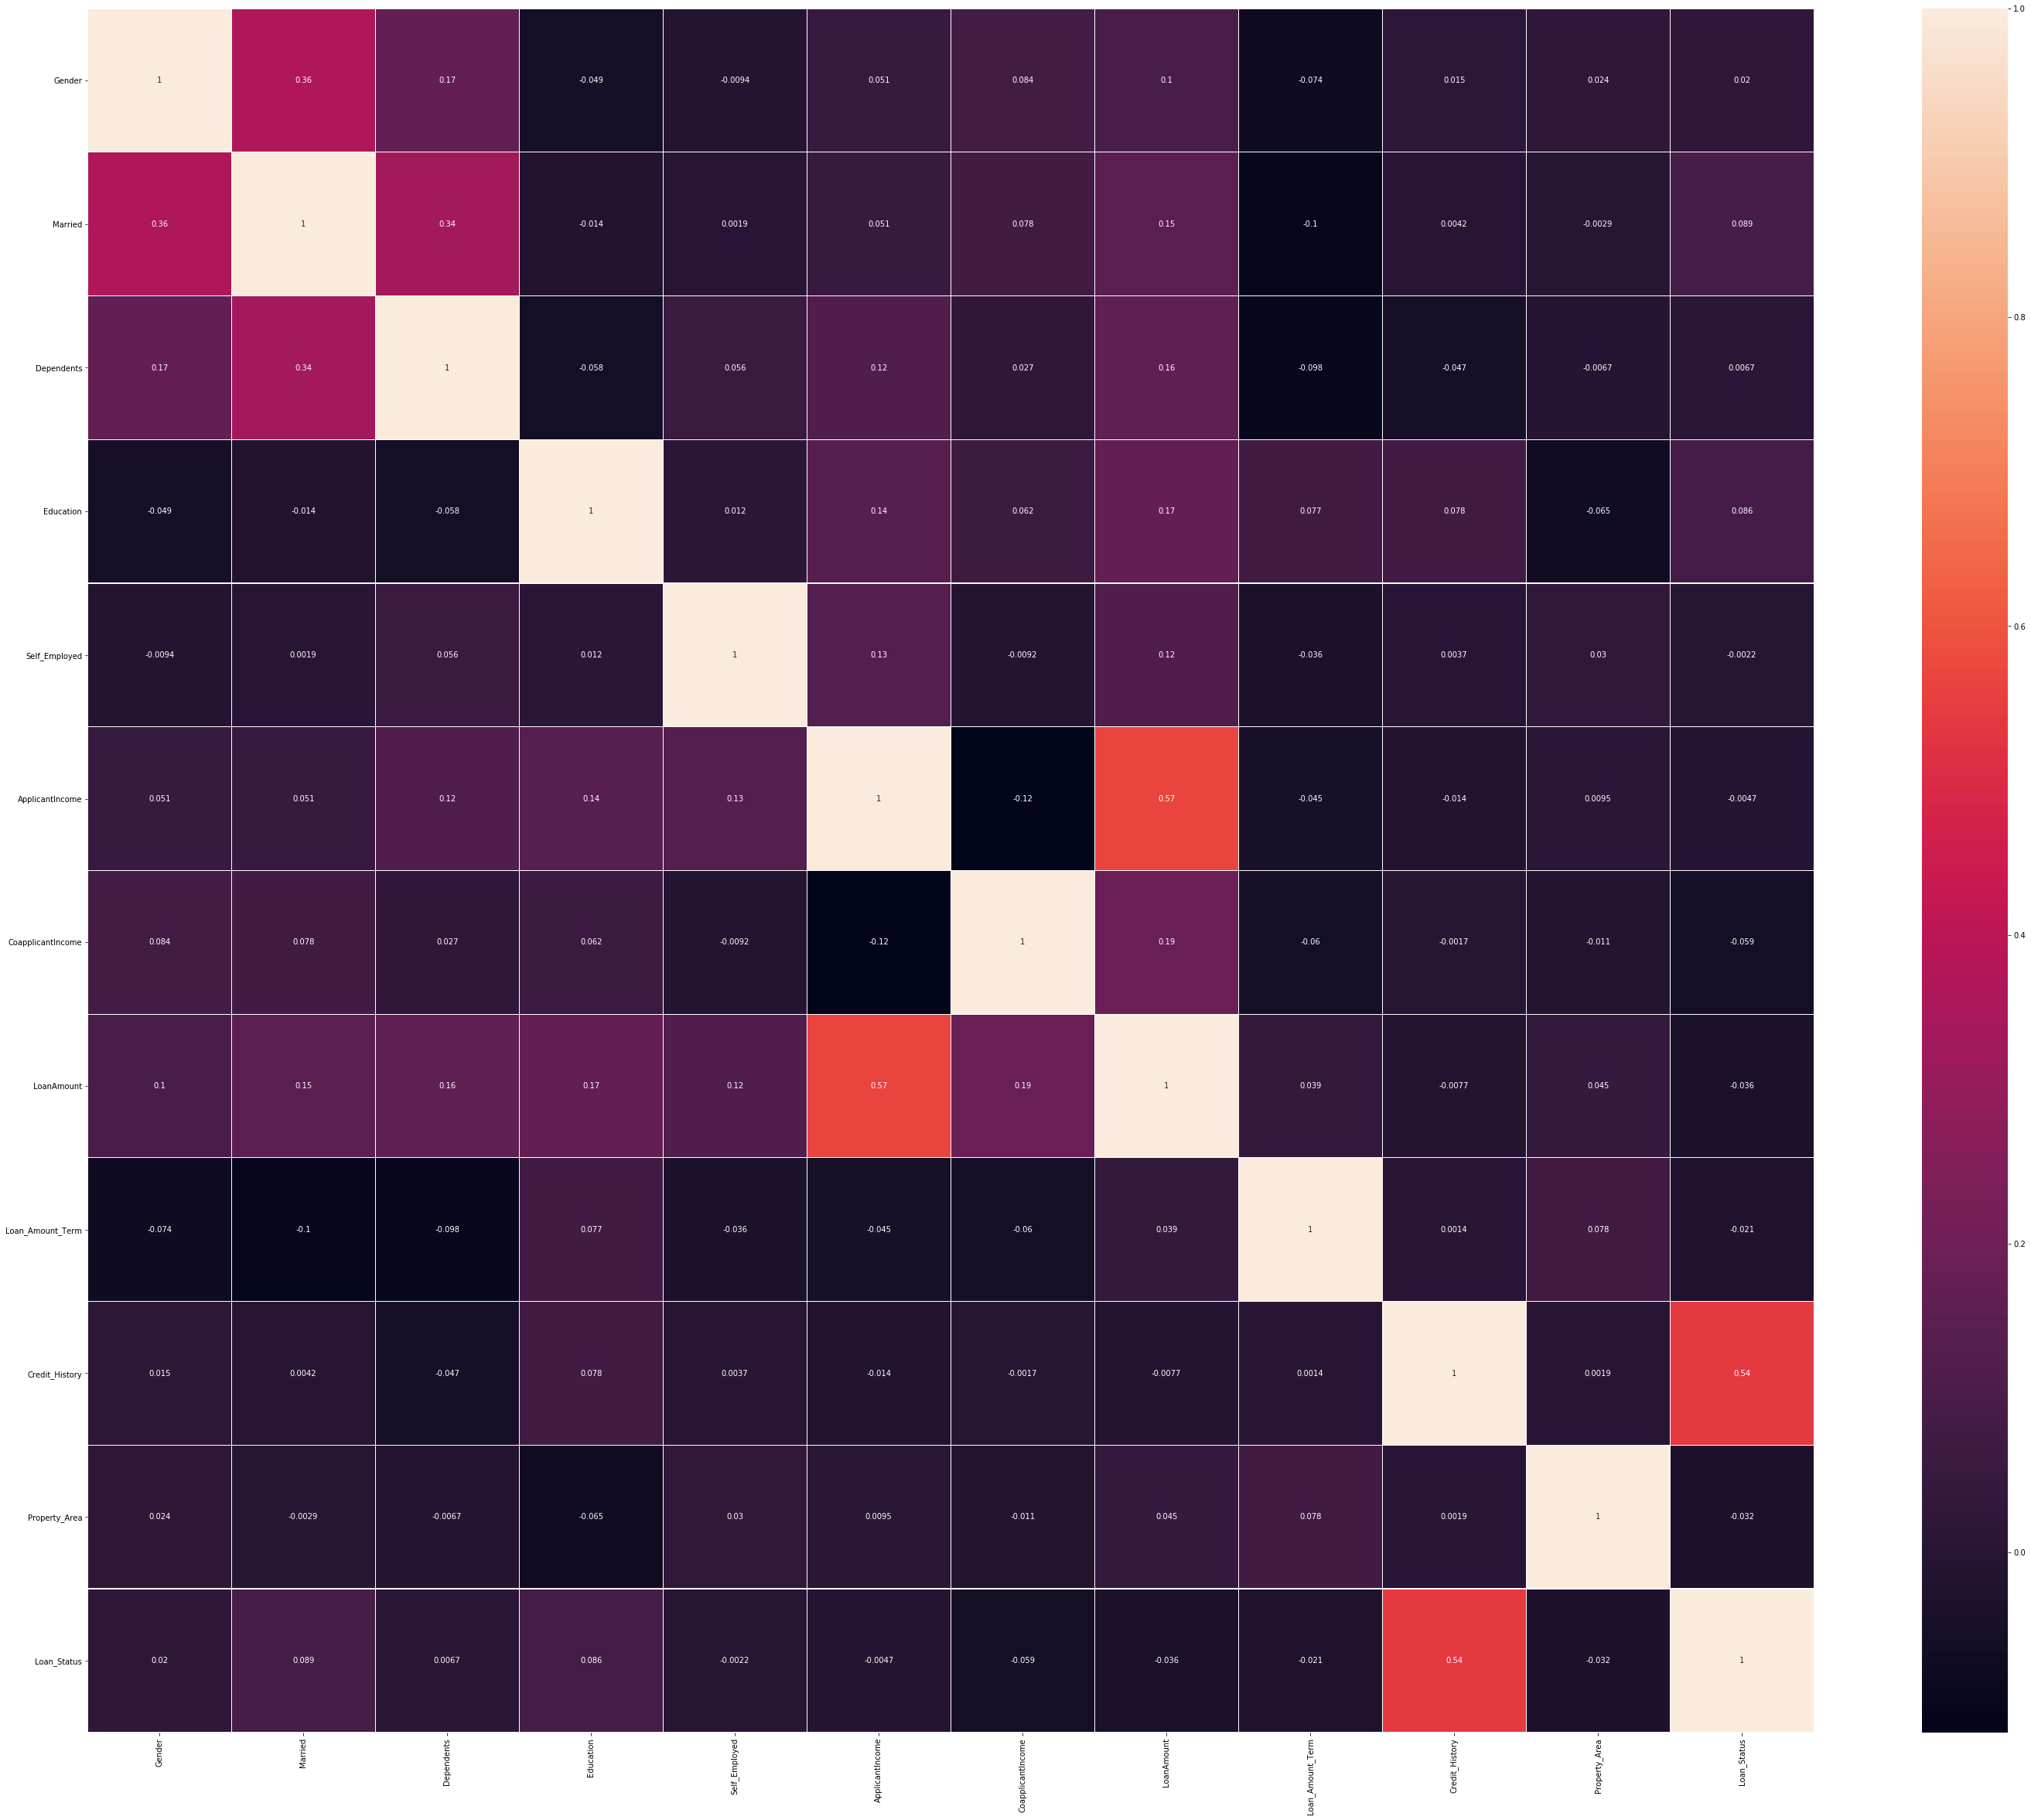

In [326]:
sns.heatmap(data.corr(),annot = True, linewidths = 0.2) # Тепловая карта корреляций (Сильной (прямой и обратной) взаимосвязи не наблюдается )
fig = plt.gcf()
fig.set_size_inches(50,41)

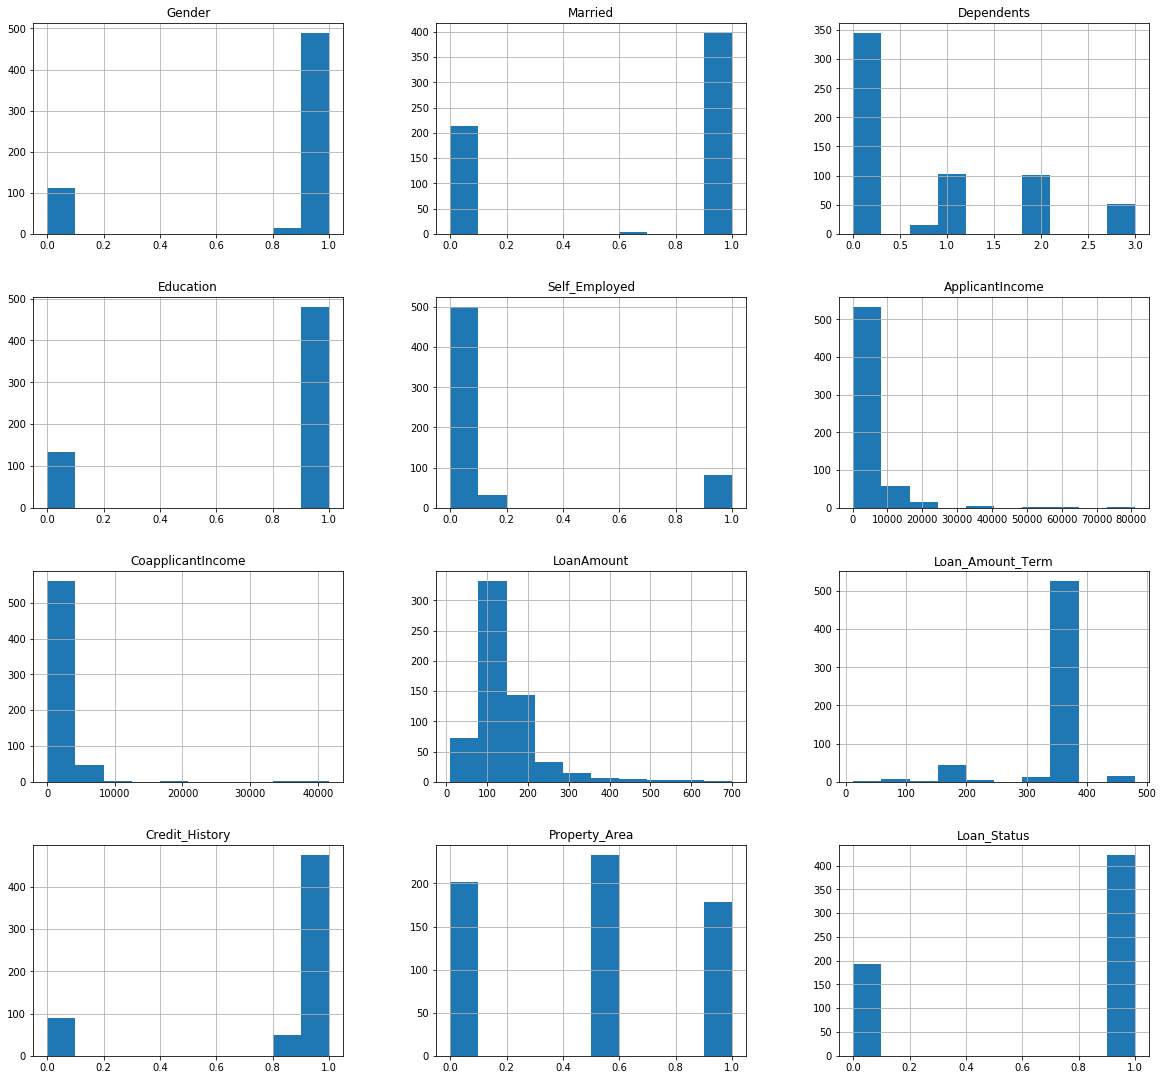

In [327]:
data.hist()
fig = plt.gcf()
fig.set_size_inches(20,19)

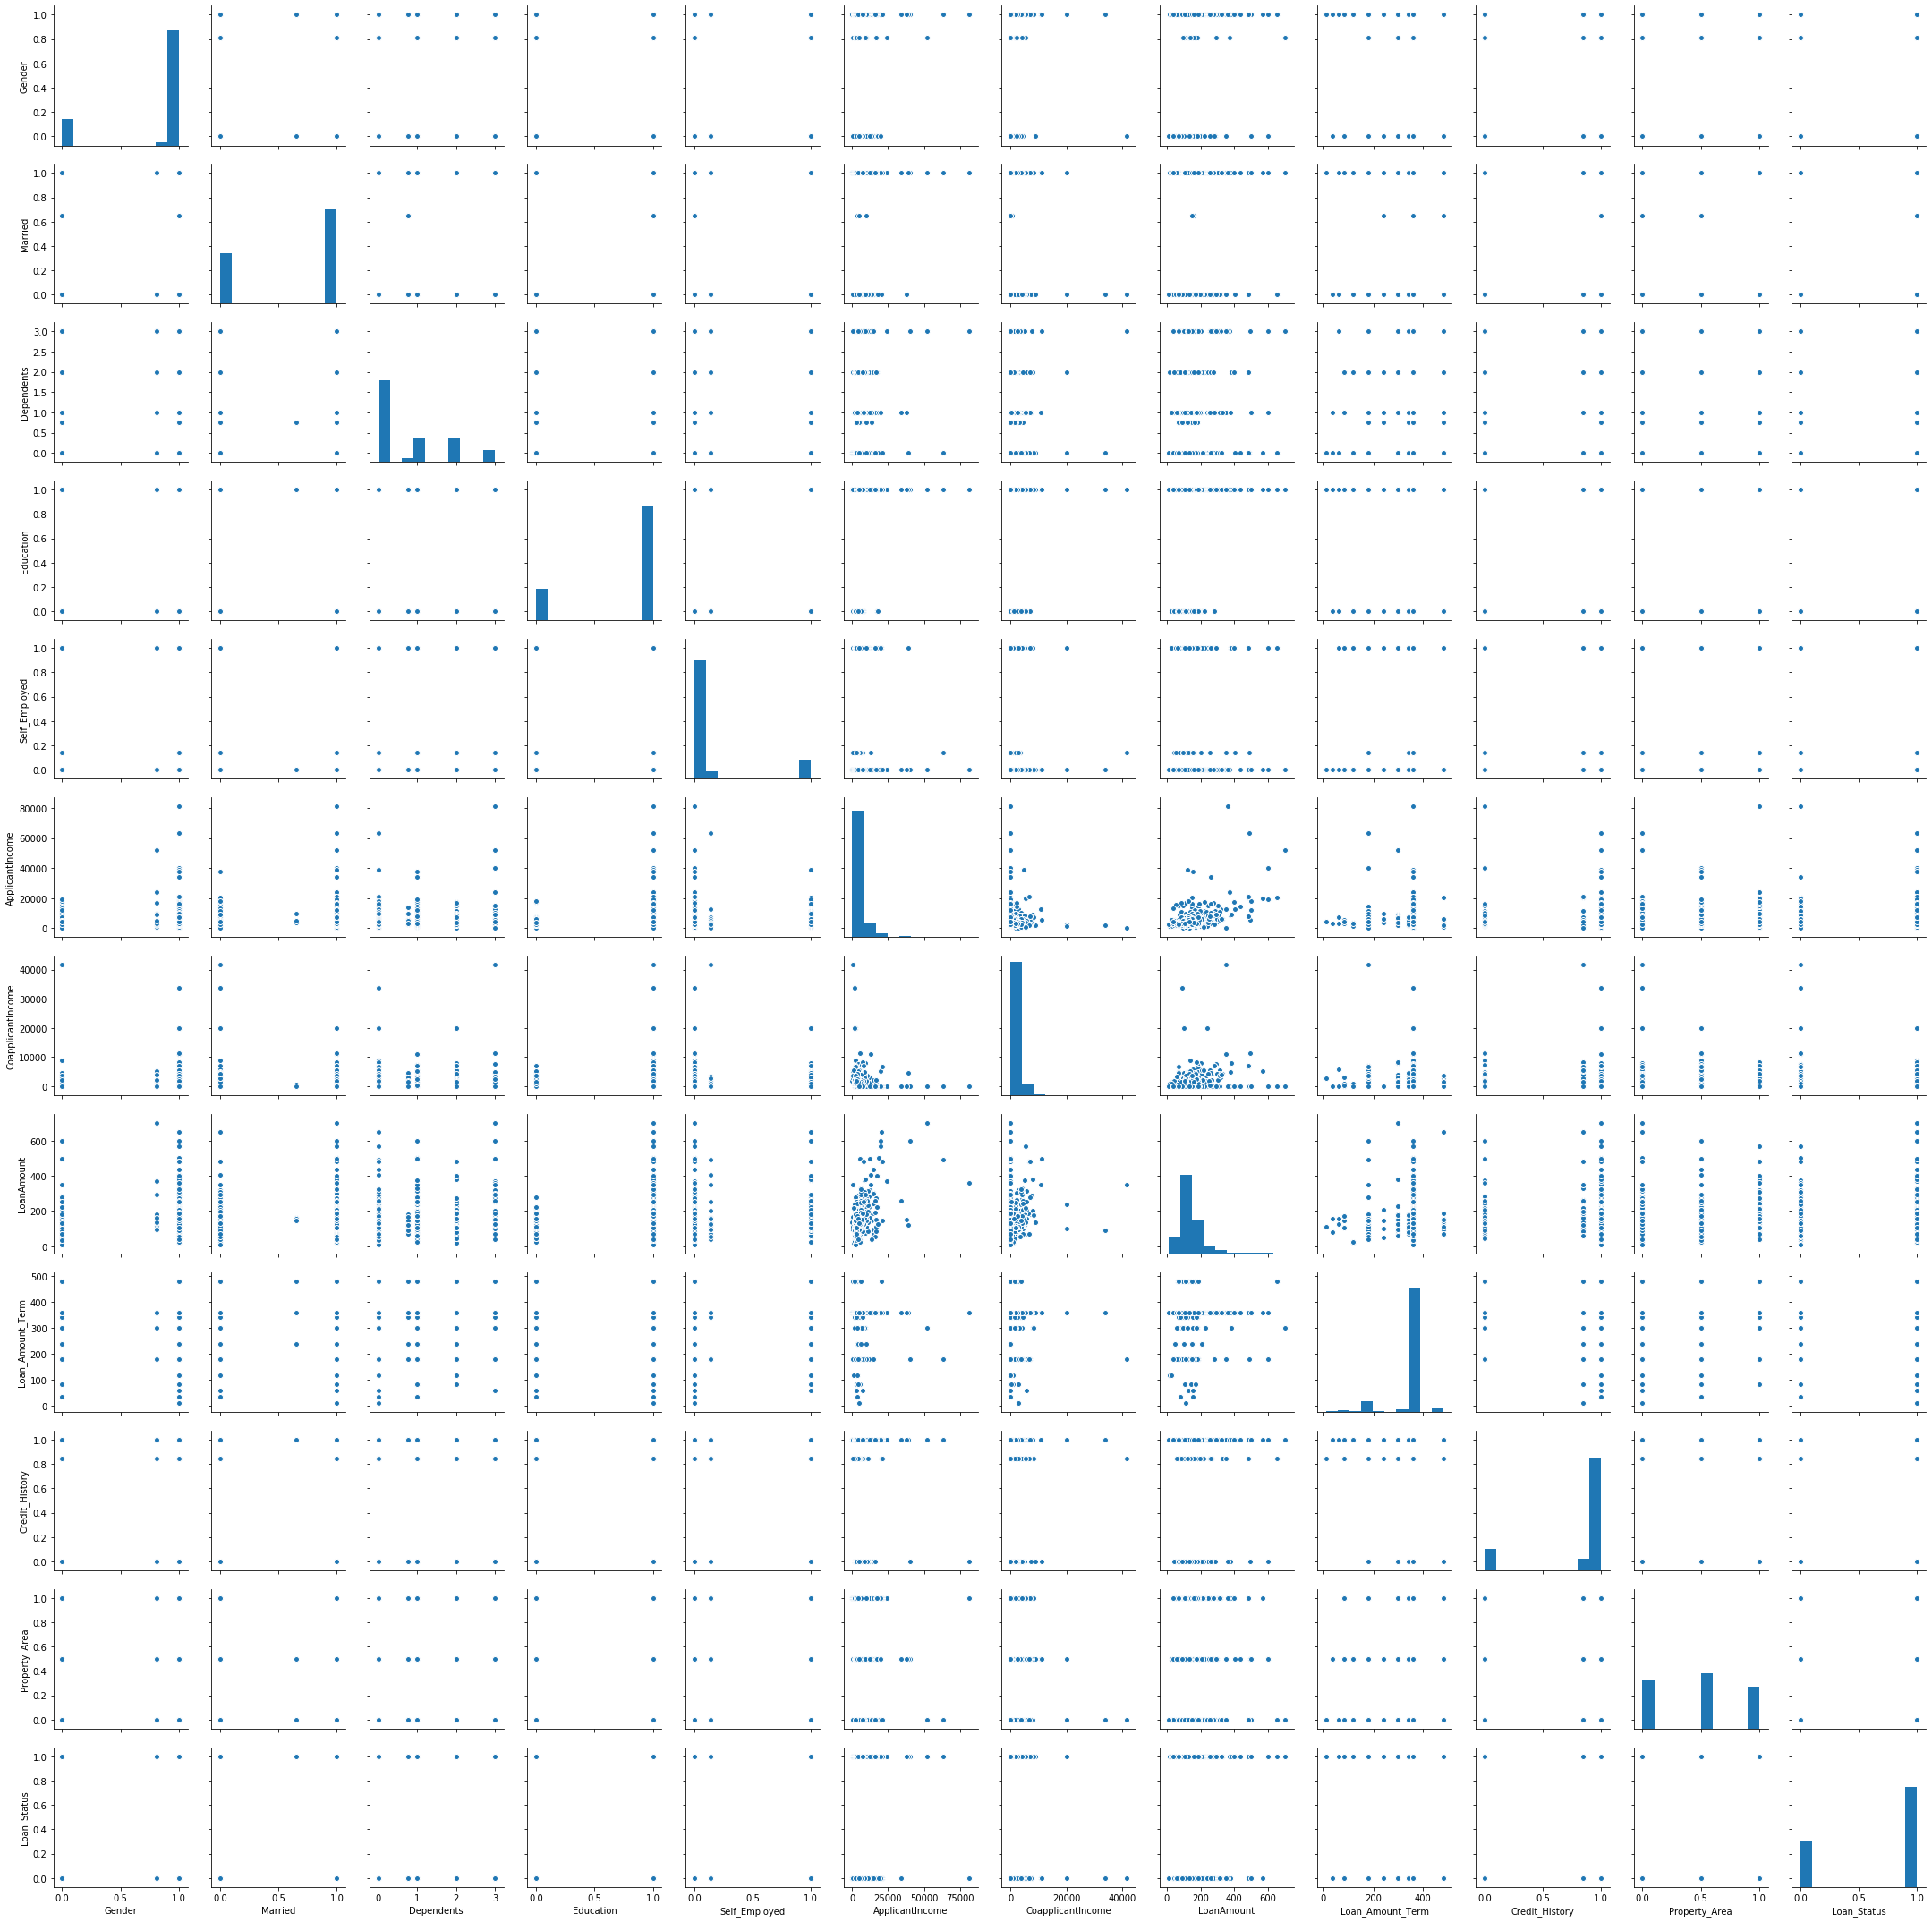

In [328]:
sns.pairplot(data)

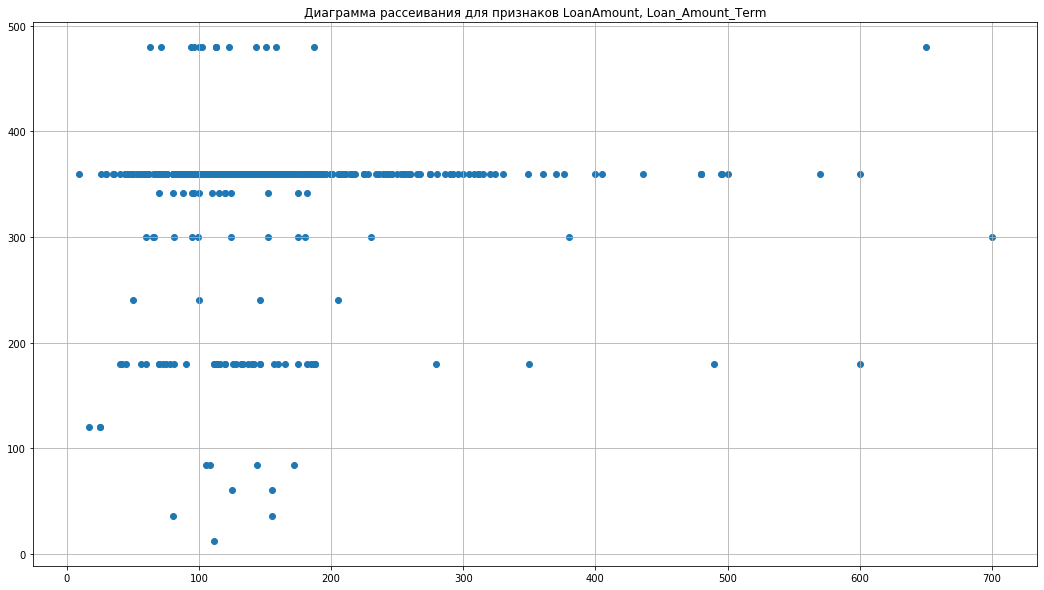

In [329]:
plt.scatter('LoanAmount','Loan_Amount_Term', data = data )
plt.grid()
plt.title('Диаграмма рассеивания для признаков LoanAmount, Loan_Amount_Term')
fig = plt.gcf()
fig.set_size_inches(18,10)
# Зависимости между этими признаками не наблюдается (по тепловой карте корреляции 0.039)

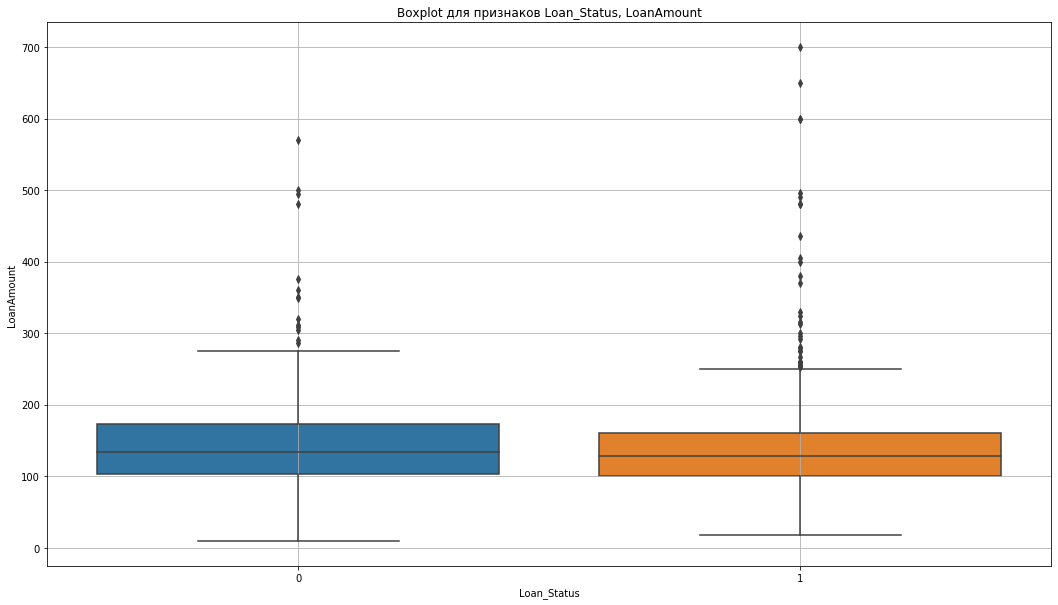

In [330]:
sns.boxplot('Loan_Status','LoanAmount', data = data)
plt.grid()
plt.title('Boxplot для признаков Loan_Status, LoanAmount')
fig = plt.gcf()
fig.set_size_inches(18,10)
# Как мы можем заметить, для данных признаков мы видим выбросы/аномалии которые следует очистить для повышения качества модели

In [331]:
# Выделяем целевую переменную
X = data.drop(['Loan_Status','Loan_ID'],axis = 1)
y = data['Loan_Status'].tolist() # Целевая переменная

In [332]:
# Мастшабирование данных
scaler = StandardScaler().fit(X)
X = scaler.transform(X)

In [333]:
# Разделяем данные на обучающую и тестовую выборку в соотношении 80/20 соответсвенно (Датасет небольшой, есть вероятность недоучиться)
X_train,X_test,y_train, y_test = train_test_split(X,y,random_state = 7, test_size = .2)

In [334]:
# Код для сравнения метрик моделей на исследуемых данных
models = [ RidgeClassifier(),SVC(),KNeighborsClassifier(),SGDClassifier(),DecisionTreeClassifier(),GaussianNB()]
dt = []
accs = []
f1s = []
ras = []
for model in models:
    
    t1 = time.time()
    model.fit(X_train,y_train)
    t2 = time.time()
    y_pred = model.predict(X_test)
    
    dt.append( t2 - t1)
    accs.append(accuracy_score(y_test,y_pred)) 
    f1s.append(f1_score(y_test,y_pred))
    ras.append(roc_auc_score(y_test,y_pred))
    
models = [str(model).split('(')[0] for model in models]   
results = pd.DataFrame({'model': models,'Accuracy':accs,'f1 score':f1s,'ROC AUC score':ras,'Fit time':dt})
models_results = pd.DataFrame(results)

In [335]:
models_results.style.set_caption('Метрики моделей').hide_index().background_gradient(cmap='Blues')

model,Accuracy,f1 score,ROC AUC score,Fit time
RidgeClassifier,0.829268,0.886486,0.744505,0.007978
SVC,0.837398,0.892473,0.750458,0.018943
KNeighborsClassifier,0.813008,0.872928,0.739469,0.002992
SGDClassifier,0.682927,0.754717,0.664835,0.001994
DecisionTreeClassifier,0.715447,0.785276,0.688645,0.004985
GaussianNB,0.813008,0.872928,0.739469,0.001995


In [336]:
# Работа с моделью 
model = SVC(probability = True).fit(X_train,y_train)
y_pred  = model.predict(X_test)
y_proba = model.predict_proba(X_test)

No handles with labels found to put in legend.


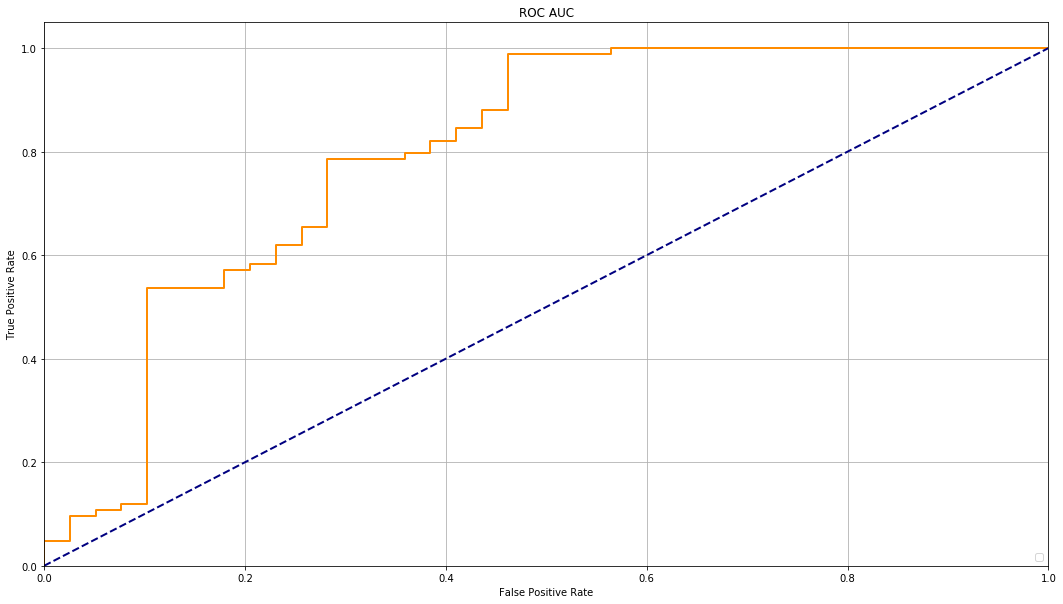

In [337]:
# График ROC AUC 
fpr , tpr , _ = roc_curve(np.array(y_test).reshape(-1,1),np.array(y_proba[:,1]).reshape(-1,1))
plt.figure()
lw = 2

fig = plt.gcf()
fig.set_size_inches(18,10)

plt.plot(fpr, tpr, color='darkorange',
         lw=lw)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC AUC')
plt.grid()

Text(0.5, 1.0, 'Предсказания')

<Figure size 432x288 with 0 Axes>

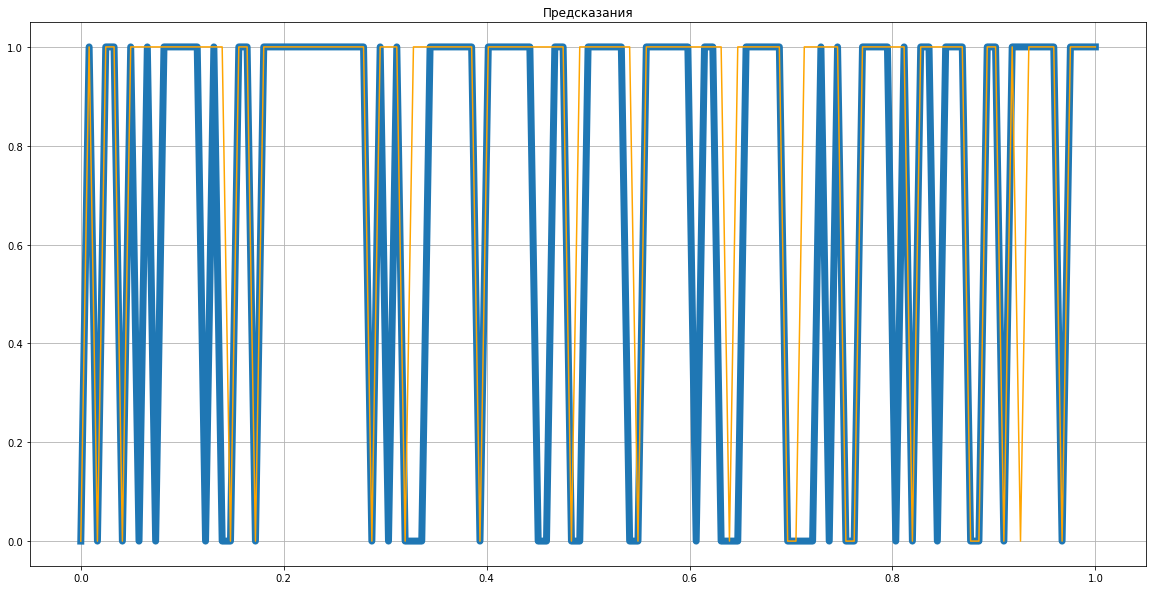

In [338]:
fig = plt.gcf()
plt.figure(figsize=(20,10))
plt.plot(np.linspace(min(y_test),max(y_test),len(y_test)),y_test , linewidth = 7)
plt.plot(np.linspace(min(y_pred),max(y_pred),len(y_pred)),y_pred , color = 'orange')
plt.grid()
plt.title('Предсказания')

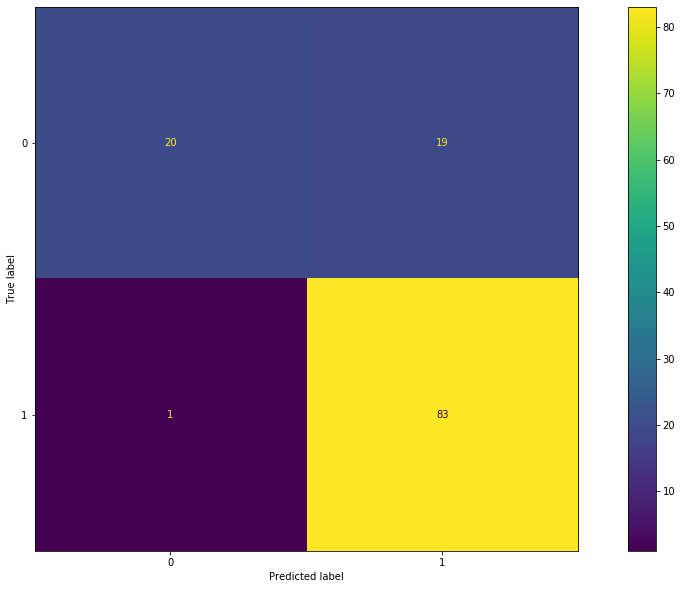

In [339]:
plot_confusion_matrix(model,X_test,y_test)
fig = plt.gcf()
fig.set_size_inches(18,10)

Попробуем убрать аномалии и посмотрим как поменяються метрики наших моделей

In [340]:
# Функция для очистки выбросов и аномалий
def clean_outlier_anomaly(df_func, whattoclean,columns):
    if whattoclean == 'anomaly':
        for i in range(len(columns)):
            IQR = np.quantile(df_func[columns[i]],0.75) - np.quantile(df_func[columns[i]],0.25)
            return df_func[(df_func[columns[i]] < (np.quantile(df_func[columns[i]],0.75) + 3*IQR))
                              & 
                              (df_func[columns[i]] > (np.quantile(df_func[columns[i]],0.25) - 3*IQR))]
    if whattoclean == 'outlier':
        for i in range(len(columns)):
            IQR = np.quantile(df_func[columns[i]],0.75) - np.quantile(df_func[columns[i]],0.25)
            return df_func[(df_func[columns[i]] < (np.quantile(df_func[columns[i]],0.75) +1.5*IQR))
                           & 
                           (df_func[columns[i]] > (np.quantile(df_func[columns[i]],0.25) - 1.5*IQR))]

In [341]:
# Применение функции
data = clean_outlier_anomaly(df_func = data, whattoclean = 'anomaly', columns = ['ApplicantIncome'])
data = clean_outlier_anomaly(df_func = data, whattoclean = 'anomaly', columns = ['LoanAmount'])

In [342]:
# Выделяем целевую переменную
X = data.drop(['Loan_Status','Loan_ID'],axis = 1)
y = data['Loan_Status'].tolist() # Целевая переменная

In [343]:
# Мастшабирование данных
scaler = StandardScaler().fit(X)
X = scaler.transform(X)

In [344]:
# Разделяем данные на обучающую и тестовую выборку в соотношении 80/20 соответсвенно (Датасет небольшой, есть вероятность недоучиться)
X_train,X_test,y_train, y_test = train_test_split(X,y,random_state = 7, test_size = .2)

In [345]:
# Код для сравнения метрик моделей на исследуемых данных
models = [ RidgeClassifier(),SVC(),KNeighborsClassifier(),SGDClassifier(),DecisionTreeClassifier(),GaussianNB()]
dt = []
accs = []
f1s = []
ras = []
for model in models:
    
    t1 = time.time()
    model.fit(X_train,y_train)
    t2 = time.time()
    y_pred = model.predict(X_test)
    
    dt.append( t2 - t1)
    accs.append(accuracy_score(y_test,y_pred)) 
    f1s.append(f1_score(y_test,y_pred))
    ras.append(roc_auc_score(y_test,y_pred))
    
models = [str(model).split('(')[0] for model in models]   
results = pd.DataFrame({'model': models,'Accuracy':accs,'f1 score':f1s,'ROC AUC score':ras,'Fit time':dt})
models_results1 = pd.DataFrame(results)

In [346]:
models_results1.style.set_caption('Метрики моделей').hide_index().background_gradient(cmap='Blues')

model,Accuracy,f1 score,ROC AUC score,Fit time
RidgeClassifier,0.808696,0.870588,0.730833,0.006981
SVC,0.808696,0.870588,0.730833,0.015955
KNeighborsClassifier,0.791304,0.858824,0.711667,0.002990
SGDClassifier,0.747826,0.824242,0.678333,0.004987
DecisionTreeClassifier,0.721739,0.789474,0.687500,0.003989
GaussianNB,0.808696,0.869048,0.736667,0.000998


Метрики упали, следует обучать модели без очистки от аномалий